# Upscalling

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot  as plt
from geone import img
from geone import imgplot as imgplt
import time

exec(open('upscalling_functions.py').read())

## Test simple upscalling function that performed a mean over a define cell spacing **from a numpy array**

### Load a ti and assign some unrealistic k value to the facies

In [2]:
streb = read_pickle('ti_strebelle_np.pickle')

In [3]:
streb = assign_k(streb, [0,1], [1,10])

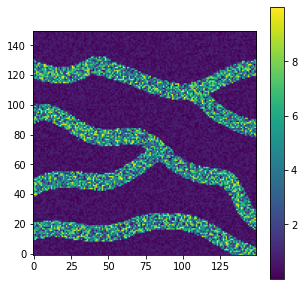

In [34]:
fig = plt.figure(figsize=(5,5))
plt.imshow(streb, origin='lower')
plt.colorbar()
plt.show()

In [35]:
fig.savefig('figure/streb.png')

### Upscalling by defining the sx, sy, sx_up and sy_up

The shape of the ouptut grid is (38, 38)
The original cells dimensions were sx = 1 and sy = 1.
The upscall cells dimensions are sx_up = 4 and sy_up = 4.
Upscalling is done!


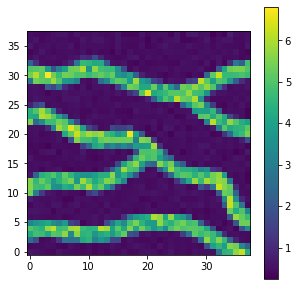

In [36]:
sx = 1
sy = 1
sx_up = 4
sy_up = 4
upscall_ti = up_array_mean(streb, sx, sy, sx_up=sx_up, sy_up=sy_up)
fig = plt.figure(figsize=(5,5))
plt.imshow(upscall_ti, origin='lower')
plt.colorbar()
plt.show()

In [37]:
fig.savefig('figure/up_mean_streb.png')

The shape of the ouptut grid is (19, 15)
The original cells dimensions were sx = 1 and sy = 1.
The upscall cells dimensions are sx_up = 10 and sy_up = 8.
Upscalling is done!


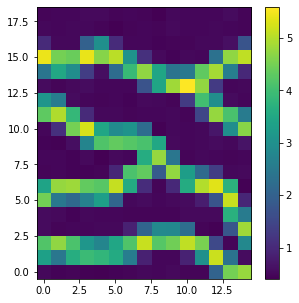

In [39]:
sx_up = 10
sy_up = 8
upscall_ti = up_array_mean(streb, sx, sy, sx_up=sx_up, sy_up=sy_up)
fig = plt.figure(figsize=(5,5))
plt.imshow(upscall_ti, origin='lower')
plt.colorbar()
plt.show()

In [40]:
fig.savefig('figure/up_mean_streb2.png')

## Test simple upscalling **to a flopy unstructured grid created with Gridgen** (also works for structured grid from Gridgen).

In [7]:
import flopy as fp
from flopy.utils.gridgen import Gridgen 
import os

flopy is installed in /home/valentin/anaconda3/envs/these/lib/python3.6/site-packages/flopy


In [47]:
#Parameters of the grid
nlay  = 1
ny_up = 15
nx_up = 15
sy_up = 10
sx_up = 10
top   = 0
botm  = -1

#Set up work space
model_dir  = 'flopy_grid'
model_name = 'grid'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#The grid has to be associated with a simulation and a ground water model
simfake = fp.mf6.MFSimulation(sim_name='grid', version='mf6', exe_name='./linux_bin/mf6', 
                             sim_ws=model_dir)

gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

dis     = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=ny_up, ncol=nx_up,
                              delr=sy_up, delc=sx_up,
                              top=top, botm=botm)

#Create the grid from Gridgen
grid = Gridgen(dis, model_ws=model_dir, exe_name='./linux_bin/gridgen')

In [48]:
#Refinement of some zones
rf0shp = os.path.join(model_dir, 'rf0')
xmin = 2 * sy_up
xmax = 4 * sy_up
ymin = 7 * sx_up
ymax = 10 * sx_up
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
grid.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))

rf1shp = os.path.join(model_dir, 'rf1')
xmin = 0 * sy_up
xmax = 30 * sy_up
ymin = 2 * sx_up
ymax = 3 * sx_up
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]

grid.add_refinement_features(rfpoly, 'polygon', 2, range(nlay))

In [49]:
#Build the grid
grid.build()

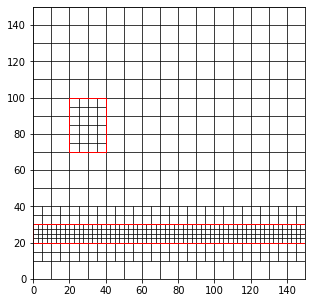

In [50]:
#Plot the grid and the different refined zones
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
grid.plot(ax, linewidth=0.5, a=None,cmap='viridis')
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='none', edgecolor='red')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='none', edgecolor='red')
plt.show()

In [51]:
fig.savefig('figure/grid1_flopy.png')

The original cells dimension were sx = 1 and sy = 1.
The upscall cells dimension are sx_up = 10.0 and sy_up = 10.0.
Upscalling is done!


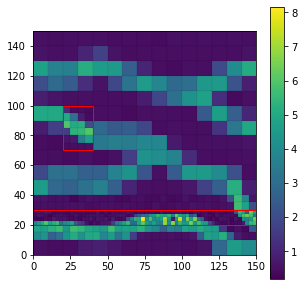

In [52]:
k_up_flopy = up_flopy_mean(streb,1,1, grid)
fig = plt.figure(figsize=(5, 5))
ax  = fig.add_subplot(1, 1, 1, aspect='equal')
a   = grid.plot(ax, linewidth=0.05, a=k_up_flopy,cmap='viridis', vmin=np.nanmin(k_up_flopy), vmax=np.nanmax(k_up_flopy))
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='none', edgecolor='red')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='none', edgecolor='red')
plt.colorbar(a)
plt.show()

In [53]:
fig.savefig('figure/streb_mean_flopy.png')

## Test to calculate the kmax et kmin iteratively **from img Geone to flopy grid**.

### Simple grid

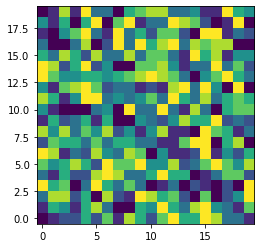

In [13]:
nx = 20
ny = 20
val_test   = np.random.randint(1,10, (ny,nx))
plt.imshow(val_test,origin='lower')

In [14]:
#Parameters of the grid
nlay  = 1
ny_up = 10
nx_up = 10
sy_up = 2
sx_up = 2
top   = 0
botm  = -1

#Set up work space
model_dir  = 'flopy_grid2'
model_name = 'grid2'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#The grid has to be associated with a simulation and a ground water model
simfake2 = fp.mf6.MFSimulation(sim_name='grid2', version='mf6', exe_name='./linux_bin/mf6', 
                             sim_ws=model_dir)

gwffake2 = fp.mf6.ModflowGwf(simfake2, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

dis2     = fp.mf6.ModflowGwfdis(gwffake2, nlay=nlay, nrow=ny_up, ncol=nx_up,
                              delr=sy_up, delc=sx_up,
                              top=top, botm=botm)

#Create the grid from Gridgen
grid2 = Gridgen(dis2, model_ws=model_dir, exe_name='./linux_bin/gridgen')
grid2.build()

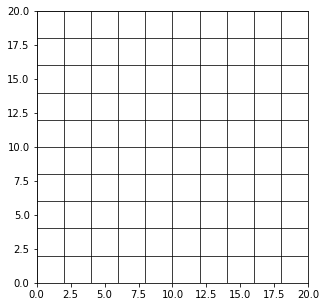

In [15]:
#Plot the grid and the different refined zones
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
grid2.plot(ax, linewidth=0.5, a=None,cmap='viridis')
plt.show()

In [16]:
grid_up = up_flopy_kb(val_test,1, 1, grid2)

The original cells dimension were sx = 1 and sy = 1.
The upscall cells dimension are sx_up = 2.0 and sy_up = 2.0.
Upscalling is done!


In [17]:
kMAX = grid_up[0]
kMIN = grid_up[1]
i=1
len(grid_up[i])

100

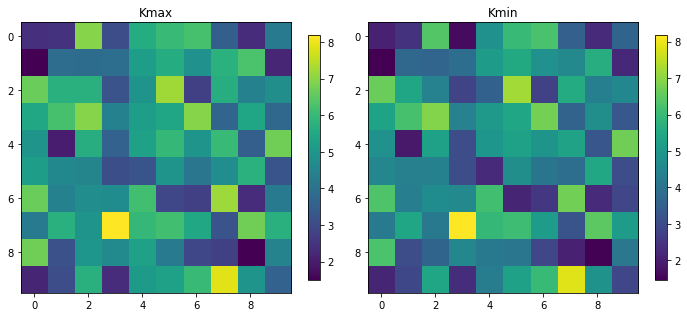

In [18]:
plt.subplots(1,2, figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.reshape(kMAX, (ny_up,nx_up)))
plt.title('Kmax')
plt.colorbar(shrink=0.35)
plt.subplot(1,2,2)
plt.imshow(np.reshape(kMIN,(ny_up,nx_up)))
plt.title('Kmin')
plt.colorbar(shrink=0.35)
plt.tight_layout()
plt.show()

### Unstructured grid

In [19]:
grid_up_streb = up_flopy_kb(streb,1,1, grid)

The original cells dimension were sx = 1 and sy = 1.
The upscall cells dimension are sx_up = 10.0 and sy_up = 10.0.
Upscalling is done!


In [20]:
kMAX = grid_up_streb[0]
kMIN = grid_up_streb[1]
i=1
len(grid_up_streb[i])

558

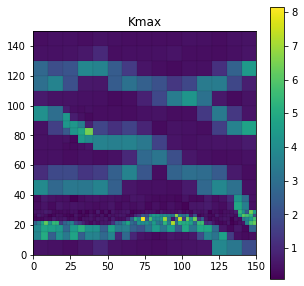

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
a = grid.plot(ax, linewidth=0.05, a=kMAX,cmap='viridis')
plt.colorbar(a)
plt.title('Kmax')
plt.show()

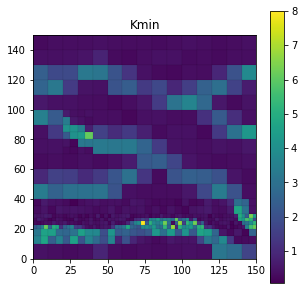

In [22]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
a = grid.plot(ax, linewidth=0.05, a=kMIN,cmap='viridis')
plt.colorbar(a)
plt.title('Kmin')
plt.show()

### Test Roussillon 2D

In [23]:
simuR = read_pickle('simu_np.pickle')

In [24]:
facies_list = [0,1,2,3,4,5]
k_list      = [1e-7,1e-2,1e-3,1e-4,5e-3,1e-6]
simu_k      = assign_k(simuR, facies_list, k_list)

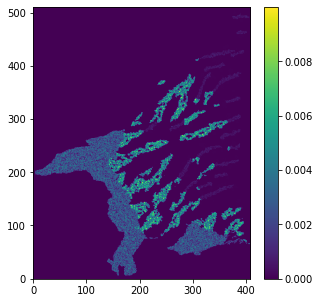

In [82]:
fig = plt.figure(figsize=(5,5))
plt.imshow(simu_k,origin='lower')
plt.colorbar()
plt.show()

In [81]:
#optionnel
simu_k[np.isnan(simu_k)]=1e-15

In [55]:
fig.savefig('figure/roussillon_simu.png')

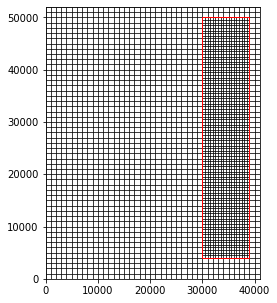

In [78]:
#Parameters of the grid
nlay = 1
ny = 52
nx = 41
sy_up = 1000
sx_up = 1000
top  = 0
botm = -1

model_dir  = 'flopy_roussillon'
model_name = 'grid3'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#The grid has to be associated with a simulation and a ground water model
simfake3 = fp.mf6.MFSimulation(sim_name='grid3', version='mf6', exe_name='./linux_bin/mf6', 
                             sim_ws=model_dir)

gwffake3 = fp.mf6.ModflowGwf(simfake3, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

dis3     = fp.mf6.ModflowGwfdis(gwffake3, nlay=nlay, nrow=ny, ncol=nx,
                              delr=sy_up, delc=sx_up,
                         top=top, botm=botm)

grid3 = Gridgen(dis3, model_ws=model_dir, exe_name='./linux_bin/gridgen')

rf0shp = os.path.join(model_dir, 'rf0')
xmin = 30 * sy_up
xmax = 39 * sy_up
ymin = 4 * sx_up
ymax = 50 * sx_up
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
grid3.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))


grid3.build()

#get some properties of the grid
fig = plt.figure(figsize=(5, 5))
ax  = fig.add_subplot(1, 1, 1, aspect='equal')
grid3.plot(ax, linewidth=0.5, a=None,cmap='viridis')
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='none', edgecolor='red')
plt.show()

In [79]:
fig.savefig('figure/grid2_roussillon.png')

In [88]:
%%time
grid_up_roussillon = up_flopy_kb(simu_k,100,100, grid3)

The original cells dimension were sx = 100 and sy = 100.
The upscall cells dimension are sx_up = 1000.0 and sy_up = 1000.0.
Upscalling is done!
CPU times: user 2min 53s, sys: 144 ms, total: 2min 53s
Wall time: 2min 53s


In [89]:
kMAX = grid_up_roussillon[0]
kMIN = grid_up_roussillon[1]
i=1
len(grid_up_roussillon[i])

3374

In [90]:
np.count_nonzero(kMAX<kMIN)

0

In [94]:
kMAX[kMAX<1e-12]=np.nan

The only cell where kmin is superior to kmax are cells composed of some nan value.

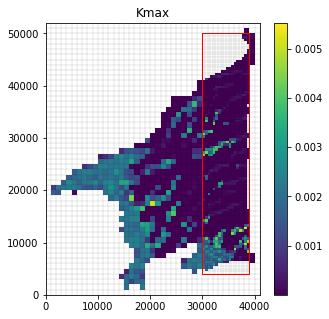

In [95]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
a = grid3.plot(ax, linewidth=0.05, a=kMAX, cmap='viridis',vmin=np.nanmin(kMAX), vmax=np.nanmax(kMAX))
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='none', edgecolor='red')
plt.colorbar(a)
plt.title('Kmax')
plt.show()

In [75]:
fig.savefig('figure/roussilon_kmax.png')

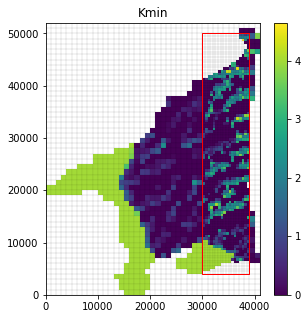

In [76]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
a = grid3.plot(ax, linewidth=0.05, a=kMIN, cmap='viridis',vmin=np.nanmin(kMIN), vmax=np.nanmax(kMIN))
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='none', edgecolor='red')
plt.colorbar(a)
plt.title('Kmin')
plt.show()

In [77]:
fig.savefig('figure/roussilon_kmin.png')

## Brouillon

In [292]:
z_start = np.random.randint(1,4,(2,2))*0.2
z_start = np.full((3,3),2)*1.2
z_start[0,0]=1
z_start[-1,0]=4

z_start, z_start.shape

(array([[1. , 2.4, 2.4],
        [2.4, 2.4, 2.4],
        [4. , 2.4, 2.4]]),
 (3, 3))

In [303]:
z_start[-1,-1] = np.nan
print(z_start)

[[nan 2.4 2.4]
 [2.4 2.4 2.4]
 [4.  2.4 nan]]


In [304]:
kx(z_start)


[2.541176470588235, 2.6999999999999997]

In [305]:
ky(z_start)

[2.7428571428571424, 2.6181818181818177]

In [33]:
def ky(grid):
    
    def kmax_y(grid):
        #ok
        val = np.copy(grid)
        while val.shape != (1,1):


            #arithmetic mean
            mean_a = []
            nt = int(np.trunc(val.shape[1]/2))
            if nt>0:
                for t in range(nt):
                    c1 = val[:,t*2]
                    c2 = val[:,t*2+1]
                    mean_a.append(np.nanmean([c1,c2], axis=0))

                val = val[:,t*2+2:]
                for m in mean_a[::-1]:
                    val = np.hstack([m.reshape(len(m),1),val])

            #harithmetic mean
            mean_h = []
            nt = int(np.trunc(val.shape[0]/2))
            if nt>0:
                for t in range(nt):
                    l1 = val[t*2]
                    l2 = val[t*2+1]
                    
                    if np.count_nonzero(~np.isnan([l1,l2])) != len(l1)+len(l2):
                        mh=[]
                        for l in range(len(l1)):
                            nb = np.count_nonzero(~np.isnan([l1[l],l2[l]]))
                            mh.append(nb/np.nansum([1/l1[l],1/l2[l]])) 
                        mh = np.array(mh)
                        mean_h.append(mh)
                        
                    else: 
                        mean_h.append(2/np.nansum([1/l1,1/l2],axis=0))

                val = val[(t*2)+2:]
                for m in mean_h[::-1]:
                    val = np.vstack([m,val])

        return val
    
    
    def kmin_y(grid):
        #ok
        val = np.copy(grid)
        while val.shape != (1,1):


            #harmonic mean
            mean_h = []
            nt = int(np.trunc(val.shape[0]/2))
            if nt>0:
                for t in range(nt):
                    l1 = val[t*2]
                    l2 = val[t*2+1]
                    
                    if np.count_nonzero(~np.isnan([l1,l2])) != len(l1)+len(l2):
                        mh=[]
                        for l in range(len(l1)):
                            nb = np.count_nonzero(~np.isnan([l1[l],l2[l]]))
                            mh.append(nb/np.nansum([1/l1[l],1/l2[l]])) 
                        mh = np.array(mh)
                        mean_h.append(mh)
                        
                    else: 
                        mean_h.append(2/np.nansum([1/l1,1/l2],axis=0))
                        

            #arithmetic mean
            mean_a = []
            nt = int(np.trunc(val.shape[1]/2))
            if nt>0:
                for t in range(nt):
                    c1 = val[:,t*2]
                    c2 = val[:,t*2+1]
                    mean_a.append(np.nanmean([c1,c2], axis=0))

                val = val[:,t*2+2:]
                for m in mean_a[::-1]:
                    val = np.hstack([m.reshape(len(m),1),val])


        return val
    
    return [kmax_y(grid), kmin_y(grid)]           
    

In [24]:
#Different test classify regarding their performance
def test_0():
    coord_x = np.arange(sx/2+ox,nx,sx)
    coord_y = np.arange(sy/2+oy,ny,sy)
    coords  = np.array([[co_x, co_y] for co_y in coord_y for co_x in coord_x])
    p_x = [int(np.trunc(cx/sx_up)) for cx in coords[:,0]]
    p_y = [int(np.trunc((cy/sy_up))*nx) for cy in coords[:,1]]
    p = np.array([[px+py] for px,py in zip(p_x,p_y)])
    d = {}
    for i,pos in enumerate(p):
        if pos[0] in d.keys():
            d[pos[0]].append(i)
        else:
            d[pos[0]] = []
            d[pos[0]].append(i)


def test_1():
    #Group Id
    groups = {}
    idCell = 0
    coord_x = np.arange(sx/2+ox,nx,sx)
    coord_y = np.arange(sy/2+oy,ny,sy)
    
    for j in range(ny):
        for i in range(nx):
            #coord = [img_objt.x()[i],img_objt.y()[j]]
            coord = [coord_x[i],coord_y[j]]
            
            for i, bound in enumerate(bounds):
                if coord[0]> bound[0][0] and coord[0]<= bound[0][1] and coord[1]> bound[1][0] and coord[1]<= bound[1][1]:
                    if i in groups.keys():
                        groups[i].append(idCell)
                        
                    else:
                        groups[i]=[]
                        groups[i].append(idCell)
                    idCell+=1
                    break
def test_2():
    #Group Id
    groups = {}
    idCell = 0
    coord_x = np.arange(sx/2+ox,nx,sx)
    coord_y = np.arange(sy/2+oy,ny,sy)
    coords = [[co_x, co_y] for co_y in coord_y for co_x in coord_x] ###Different mais plus lent

    for coord in coords:
        for i, bound in enumerate(bounds):
             if coord[0]> bound[0][0] and coord[0]<= bound[0][1] and coord[1]> bound[1][0] and coord[1]<= bound[1][1]:
                if i in groups.keys():
                    groups[i].append(idCell)
                        
                else:
                    groups[i]=[]
                    groups[i].append(idCell)
                idCell+=1
                break
    
def test_3() : 
    groups = {}
    idCell = 0
    coord_x = np.arange(sx/2+ox,nx,sx)
    coord_y = np.arange(sy/2+oy,ny,sy)
    coords = [[co_x, co_y] for co_y in coord_y for co_x in coord_x] ###Different mais plus lent
    groups = {}
    
    for id_b, bound in enumerate(bounds):
        groups[id_b] = [id_cell for id_cell,coord_cell in enumerate(coords) if coord_cell[0]> bound[0][0] and coord_cell[0]<= bound[0][1] and coord_cell[1]> bound[1][0] and coord_cell[1]<= bound[1][1]]
    